## Make blinded Wiggle plot + Resiudal FFTs from both stations using pandas! 

In [1]:
import sys,os
# sys.path.append(os.environ["JUPYROOT"]) # where JUPYROOT is path to ROOT e.g. /usr/local/Cellar/root/6.18.04/lib/root
# for Python3 install root_numpy with "python3 -m pip install --user root_numpy"
# import root_numpy # see http://scikit-hep.org/root_numpy/install.html  
# for Python3 install root_pandas with "python3 -m pip install --user root_pandas"
# from root_pandas import read_root # see https://github.com/scikit-hep/root_pandas 
import pandas as pd

## Read in the ROOT Trees into a pandas data frame (only the columns that we need for speed!)
### loading ROOT Tuple once and forgetting ROOT ever exsisted! 
### %time to measure the load time, whcih is ~7s for 3 data columns of 35M tracks!

In [2]:
data = pd.read_hdf('../DATA/HDF/Sim/VLEDM.h5', 'sim', columns=["station", "trackT0", "trackMomentum"])
data.head() # look at the first 5 entries

,station,trackT0,trackMomentum
0,12,95.009406,561.682373
1,0,96.709414,1574.397461
2,18,80.277852,2544.615967
3,0,42.755086,2182.920654
4,12,17.142041,186.225159


## Convert time ns - > us, apply station, momentum and time cuts

In [3]:
#Convert time 
# data['trackT0'] = data['trackT0']*1e-3  # ns -> us  

# Cuts:
time_cut= (data['trackT0'] > 0)  # us, define a time_cut with time > 30 us 
mom_cut = (data['trackMomentum'] > 1800) # MeV 
s12_cut = (data['station'] == 12)
s18_cut = (data['station'] == 18)

#Apply cuts in one go!
data_s12 = data[time_cut & mom_cut & s12_cut]
data_s18 = data[time_cut & mom_cut & s18_cut]

In [4]:
#Check out two data frames make sense after cuts
print(data_s12.head(), "\n", data_s18.head())
t_s12 = data_s12['trackT0']
t_s18 = data_s18['trackT0']
t_stations = [t_s12, t_s18]  # just need the track time as an array 
n_stations = ["S12", "S18"]

    station    trackT0  trackMomentum
6        12  10.879105    2120.369385
23       12  59.367961    1947.019653
53       12  53.986875    2143.992188
55       12  22.248420    2372.872314
72       12  24.466383    2486.298340 
     station     trackT0  trackMomentum
2        18   80.277852    2544.615967
20       18  204.562281    2131.132812
27       18   85.950953    1998.191772
34       18   23.729727    2406.694580
35       18   43.289961    1870.783691


### Define blinded fit function $N(t)=Ne^{-t/\tau}[1+A\cos(\omega_at+\phi)]$,
where  
[0] $N$ is the overall normalisation  
[1] $\tau$ is the boosted muon lifetime $\tau = \gamma \cdot \tau_0 = 29.3\cdot2.2=66.44 \, \mu$s  
[2] $A$ is the asymmetry  
[3] $\omega_a$ is the anomalous precision frequency (blinded)  
[4] $\phi$ is the initial phase  

In [5]:
import sys, os
# sys.path.append("../Blinding/") # folder with Blinders and libBlinders.so
# from BlindersPy3 import Blinders
# from BlindersPy3 import FitType
# getBlinded = Blinders(FitType.Omega_a, "EDM all day") 

def blinded_wiggle_function(x, *pars):
    norm  = pars[0]
    life  = pars[1]
    asym  = pars[2]
#     R     = pars[3]
    omega = pars[3]
    phi   = pars[4]
    
    time  = x
#     omega = getBlinded.paramToFreq(R)
    
    return norm * np.exp(-time/life) * (1 + asym*np.cos(omega*time + phi))

## Bin data

In [6]:
import numpy as np
sys.path.append('../CommonUtils/') # https://github.com/glukicov/EDMTracking/tree/master/CommonUtils
import CommonUtils as cu

bin_w = 150*1e-3 # 150 ns 
min_x = 30 # us
max_x = 300 # us 
print("Min [us]:", min_x)
print("Max [us]:", max_x)

# arrays to store frequencies, bin_centres for S12 and S18
x, y = [[], []], [[],[]]

# just call x,y = frequencies, bin_centres for plotting and fittnig 
for i in range(len(t_stations)):
    x[i], y[i] = cu.get_freq_bin_c_from_data(t_stations[i], bin_w, (min_x, max_x) )

Min [us]: 30
Max [us]: 300


### Define expected frequencies in the FFT spectrum

In [19]:
cbo_f = 0.37 # MHz n=0.108 (60h)
gm2_f = 0.23 # MHz 
cbo_M_gm2_f = cbo_f - gm2_f 
cbo_P_gm2_f = cbo_f + gm2_f
vm_f = 10*gm2_f  #  (60h) analyical: f_vm = f_c - 2*f_ybo



## Fit and plot: 3 subplots per station: 1) Fit+Data 2) Fit residual 3) FFT

S12
Pars_ : 1110.7739207113243 63.39205961416085 0.37963253303152905 1.4413190410519285 3.090618255113202
Pars_e: 4.370603987090874 0.15052277896291327 0.0027127022918988254 0.00013672026634534186 0.01438642975092345
Fit 𝝌2/DoF=1.2
S18
Pars_ : 1076.31165212707 63.54015290708684 0.37827641850980803 1.4409936860918418 3.1134379942376156
Pars_e: 4.205828281959679 0.1500519428919874 0.0026947552684893615 0.00013644022942013658 0.014342744114771705
Fit 𝝌2/DoF=1.15


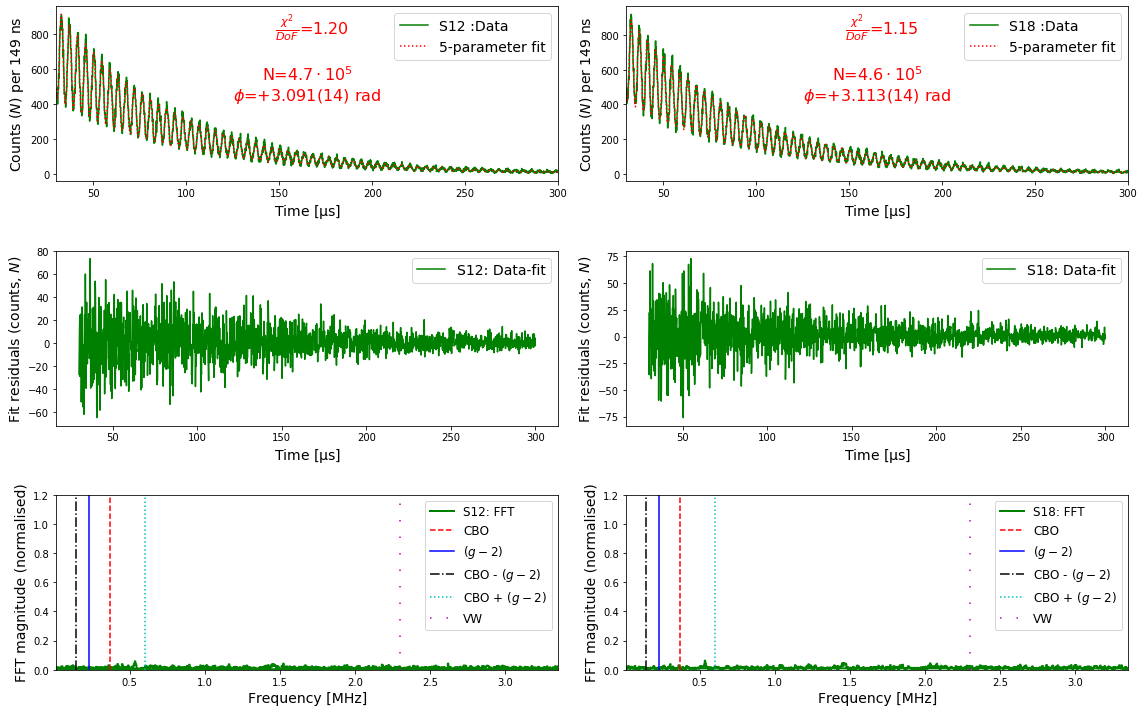

In [20]:
from scipy import optimize, stats
from scipy import fftpack
import matplotlib.pyplot as plt
%matplotlib inline

font_size=14
fig, axes = plt.subplots(3, len(n_stations), figsize=(16, 10))
     
# starting pars (1.0 = default)
p0=(15841, 64.0, 0.3, omega_a, 1.0) 
N = len(n_stations)

#storage 
fit_params = [[], []]
residuals=[[],[]]
chi2_ndf = [[], []]

# loop over the t0 of both stations: fit and plot
for i in range(N):
        
    print(n_stations[i])    

    y_err = np.sqrt(y[i]) # sigma =sqrt(N)

    ### Fit
    # Levenberg-Marquardt algorithm as implemented in MINPACK
    par, pcov = optimize.curve_fit(f=blinded_wiggle_function, xdata=x[i], ydata=y[i], sigma=y_err, p0=p0, absolute_sigma=False, method='lm')
    fit_params[i]=par
    par_e = np.sqrt(np.diag(pcov))
    print("Pars_ :", *par)
    print("Pars_e:",*par_e)
    chi2_ndf[i], chi2, ndf=cu.chi2_ndf(x[i], y[i], y_err, blinded_wiggle_function, par)
    print("Fit 𝝌2/DoF="+str(round(chi2_ndf[i],2)) )

    ### Plot 
    axes[0][i].step(x=x[i], y=y[i], where="post", color="g", label=n_stations[i]+" :Data")
    axes[0][i].plot(x[i], blinded_wiggle_function( x[i], *par ) , color="red", label='5-parameter fit', linestyle=":")
    axes[0][i].set_xlim(min_x, max_x)
    axes[0][i].legend(fontsize=font_size)
    axes[0][i].set_xlabel(xlabel=r"Time [$\rm{\mu}$s]", fontsize=font_size)
    axes[0][i].set_ylabel(ylabel=r"Counts ($N$) per "+str(int(bin_w*1e3))+" ns", fontsize=font_size)
    legend_chi2=cu.legend1_fit(chi2_ndf[i])+"\n"
    legend_N="N="+cu.sci_notation(len(t_stations[i]))+"\n"
    legned_par=cu.legend_par("",  [r"$\phi$"], [par[4]], [par_e[4]], ["rad"], prec=3)
    cu.textL(axes[0][i], 0.5, 0.65, legend_chi2+legend_N+legned_par, font_size=16, color="red")
    
    # Get resiudals for next section 
    residuals[i] = cu.residuals(x[i], y[i], blinded_wiggle_function, par)
    
# residual plots
for i in range(N):
    axes[1][i].plot(x[i], residuals[i], c='g', label=n_stations[i]+": Data-fit")
    axes[1][i].set_ylabel(r"Fit residuals (counts, $N$)", fontsize=font_size);
    axes[1][i].set_xlabel(r"Time [$\mathrm{\mu}$s]", fontsize=font_size)
    axes[1][i].legend(fontsize=font_size)
    
# FFT plots
for i in range(N):
    
    # detrend data (trying to remove the peak at 0 Hza)
    res_detrend = np.subtract(residuals[i], np.average(residuals[i]))

    #Normalise
    norm = 35000 # arbitary 
    res_detrend=res_detrend/norm

    res_fft = fftpack.fft(res_detrend) # return DFT on the fit resiudals
    res_fft = np.absolute(res_fft) # magnitude of the complex number 
    freqs = fftpack.fftfreq(len(res_detrend), d=bin_w)  # DFT sample frequencies (d=sample spacing, ~150 ns)

    axes[2][i].step(freqs, res_fft, label=n_stations[i]+": FFT", lw=2, c="g")

    #set plot limits
    x_min, x_max, y_min, y_max = 0.01, np.max(freqs), 0,  1.2
    axes[2][i].set_xlim(x_min, x_max)
    axes[2][i].set_ylim(y_min, y_max)

    #plot expected frequencies
    axes[2][i].plot( (cbo_f, cbo_f), (y_min, y_max), c="r", ls="--", label="CBO")
    axes[2][i].plot( (gm2_f, gm2_f), (y_min, y_max), c="b", ls="-", label=r"$(g-2)$")
    axes[2][i].plot( (cbo_M_gm2_f, cbo_M_gm2_f), (y_min, y_max), c="k", ls="-.", label=r"CBO - $(g-2)$")
    axes[2][i].plot( (cbo_P_gm2_f, cbo_P_gm2_f), (y_min, y_max), c="c", ls=":", label=r"CBO + $(g-2)$")
    axes[2][i].plot( (vm_f, vm_f), (y_min, y_max), c="m", ls=(0, (1, 10)), label="VW")

    axes[2][i].legend(fontsize=12, loc="best")
    axes[2][i].set_ylabel("FFT magnitude (normalised)", fontsize=font_size)
    axes[2][i].set_xlabel("Frequency [MHz]", fontsize=font_size);

    
fig.tight_layout()
fig.savefig("../fig/both_stations.png", dpi=300)

In [21]:
lifetime = 64; # us 
phase = -0.05; # rad S12 

gm2_asym = 0.45 
bin_w = 0.149 # us
bin_count = 4000 

N_inject = int(2e6)

In [24]:
def f_vertical(t, *pars):
    N=pars[0]
    A_w=pars[1]
    omega=pars[2]
    phi=pars[3]
    A_edm=pars[4]
    return N*( A_w*np.cos(omega*t+phi) + A_edm*np.sin(omega*t+phi))



In [ ]:
## Modulated time 